# Problem Statement:
## The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).



# 1. Importing the Libraries

In [79]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42)

In [80]:
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Loading the Data

In [4]:
import json

In [5]:
DATASET_PATH = os.path.join("/Users", "ojasbardiya", "Downloads")

In [6]:
def load_data(data_path, file_name):
    
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path, sep=';')

In [7]:
df_main = load_data(DATASET_PATH, 'bank-additional/bank-additional-full.csv')

# 2. Basic Stats and EDA

In [8]:
df_main.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
df_main.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [10]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [11]:
df_main.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Text(0.5, 1.0, 'Correlation between different features')

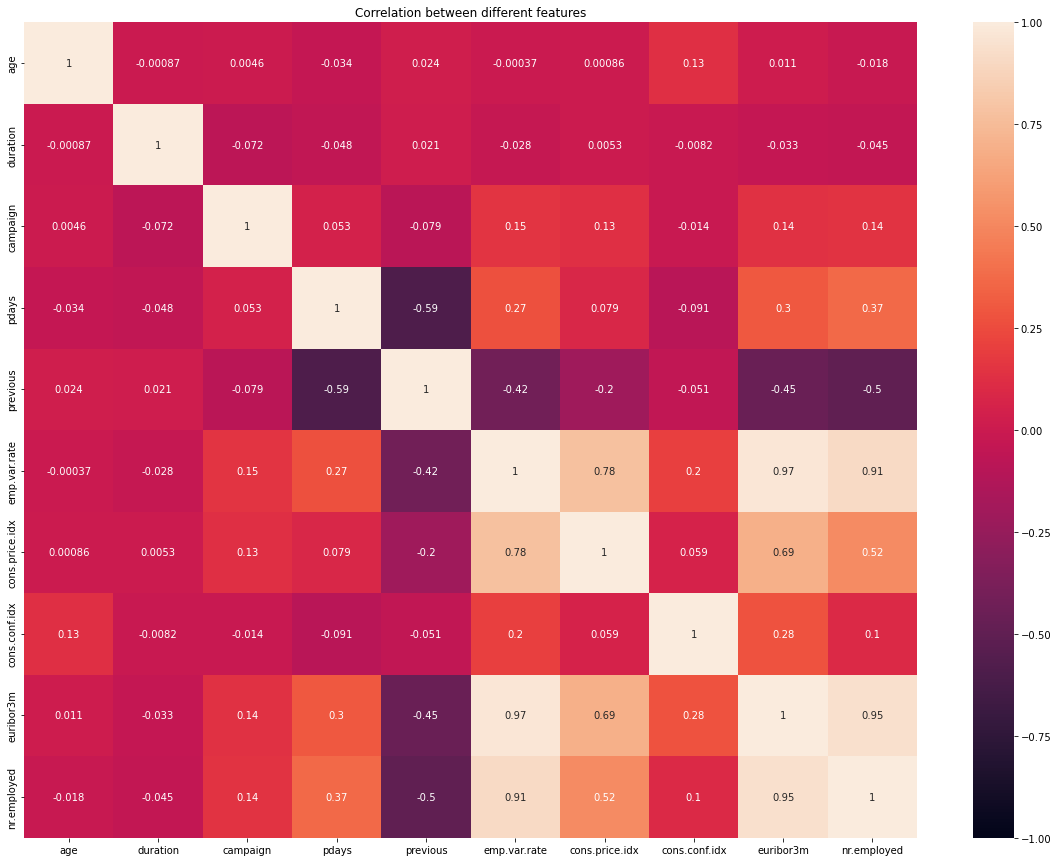

In [12]:
plt.figure(figsize=(20, 15))
hmap = sns.heatmap(df_main.corr(), vmin=-1, vmax=1, annot=True)
hmap.set_title('Correlation between different features')

In [13]:
df_main["y"].unique()

array(['no', 'yes'], dtype=object)

Text(0.5, 1.0, 'Count of subscribers/non-subscribers')

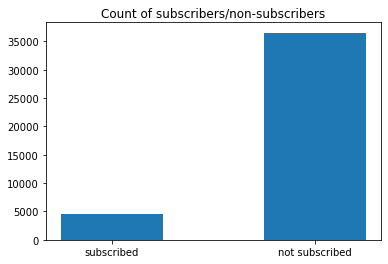

In [14]:
s = df_main[df_main['y'] == 'yes'].shape[0]
ns = df_main[df_main['y'] == 'no'].shape[0]
x = ["subscribed", "not subscribed"]
y = [s, ns]
plt.bar(x, y, width=0.5)
plt.title('Count of subscribers/non-subscribers')

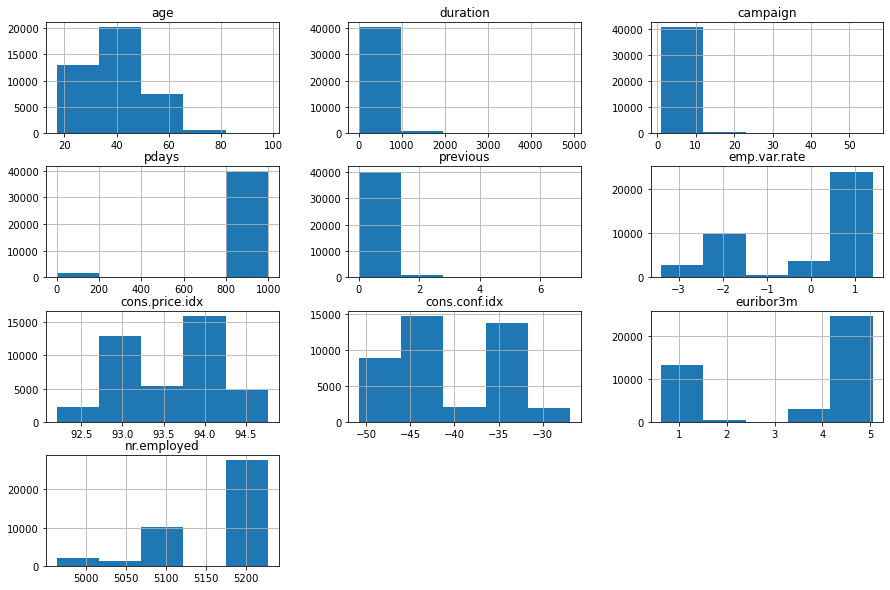

In [15]:
df_main.hist(bins=5, figsize=(15,10))
plt.show()

In [16]:
#function to analyze subscription data based on other features in the dataset
def get_bar(col):
    vis = df_main[[col, "y"]]
    sub_counts = pd.crosstab(vis[col], vis["y"])
    #normalizing the count so we can express the result as a percentage
    sub_pcts = sub_counts.div(sub_counts.sum(1), axis=0)
    sub_pcts.plot.bar()

## Subscriptions (and non-subscriptions) per Month

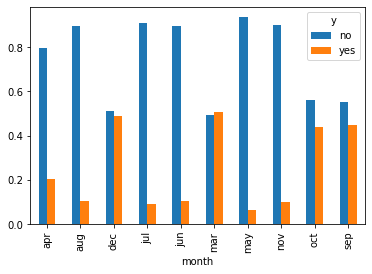

In [17]:
get_bar("month")

## Subscriptions (and non-subscriptions) per Employment Status

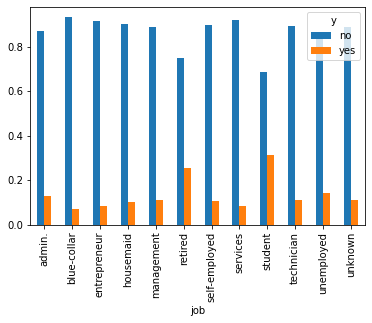

In [18]:
get_bar("job")

## Subscriptions (and non-subscriptions) per Marital Status

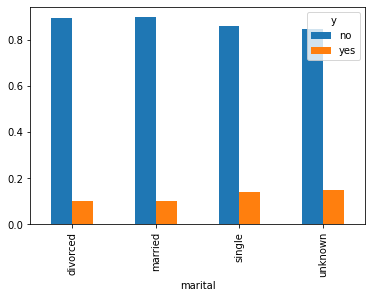

In [19]:
get_bar("marital")

# 3. Pipeline and Data Augmentation

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [21]:
df1 = df_main.copy()
df1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

## Determining categorization strategy
## OHE - one hot encoding
## LE - label encoding

In [22]:
df1['job'].unique() #OHE

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [23]:
df1['marital'].unique() #OHE

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [24]:
df1['education'].unique() #OHE

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [25]:
df1['default'].unique() #OHE

array(['no', 'unknown', 'yes'], dtype=object)

In [26]:
df1['housing'].unique() #OHE

array(['no', 'yes', 'unknown'], dtype=object)

In [27]:
df1['loan'].unique() #OHE

array(['no', 'yes', 'unknown'], dtype=object)

In [28]:
df1['contact'].unique() #LE

array(['telephone', 'cellular'], dtype=object)

In [29]:
df1['poutcome'].unique() #OHE

array(['nonexistent', 'failure', 'success'], dtype=object)

## Building the Pipeline

In [30]:
df1_features = df1.drop("y", axis=1)
df1_labels = df1["y"].copy()

In [31]:
df1_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [32]:
#Label encoding binary features prior to pipeline transformation
le = LabelEncoder()
for col in ["contact"]:
    df1_features[col] = le.fit_transform(df1_features[col])

In [33]:
df1_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  int64  
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [34]:
# This cell implements the complete pipeline for preparing the data

#In case we need to augment features
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

imputer = SimpleImputer(strategy="mean") # use mean imputation for missing values

#Remove the non-numerical features
df1_num = df1_features.drop(["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"], axis=1)

#age_idx, bmi_idx = 0 , 2

'''
class AugmentFeatures(BaseEstimator, TransformerMixin):
    #implements the previous features we had defined
    #df1['bmi_x_age'] = df1["bmi"]*df1["age"]
    def __init__(self, add_bmi_x_age = True): 
        self.add_bmi_x_age = add_bmi_x_age
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        final = X
        if self.add_bmi_x_age:
            bmi_x_age = X[:, bmi_idx] * X[:, age_idx]
            final = np.c_[X, bmi_x_age]
        return final

attr_adder = AugmentFeatures()
df1_extra_attribs = attr_adder.transform(df1.values) # generate new features
'''
#Numerical Pipeline
# 1. impute (if needed)
# 2. Augment the feature set (if needed)
# 3. Normalize using StandardScaler()
num_pipeline = Pipeline([ #('imputer', SimpleImputer(strategy="mean")), #('attribs_adder', AugmentFeatures()), 
        ('std_scaler', StandardScaler())])

df1_num_tr = num_pipeline.fit_transform(df1_num)

numerical_features = list(df1_num)
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "month", "day_of_week", "poutcome"]

full_pipeline = ColumnTransformer(transformers=[
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features)],
    remainder='passthrough')

data_prepared = full_pipeline.fit_transform(df1_features)

In [35]:
data_prepared

array([[ 1.53303429,  0.01047142, -0.56592197, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.62899323, -0.42150051, -0.56592197, ...,  1.        ,
         0.        ,  1.        ],
       [-0.29018564, -0.12451981, -0.56592197, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.53303429, -0.26722482, -0.20490853, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.38152696,  0.70856893, -0.56592197, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.26029527, -0.07438021,  0.15610492, ...,  0.        ,
         0.        ,  0.        ]])

In [36]:
data_prepared.shape

(41188, 62)

# 4. PCA and splitting the data

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import decomposition

In [38]:
pca_data = data_prepared.copy()

In [39]:
pca = decomposition.PCA(0.8)
pca_data = pca.fit_transform(pca_data)

In [40]:
pca_data.shape

(41188, 13)

In [65]:
df1_labels = df1_labels.map({'yes': 1, 'no': 0})

In [66]:
Xp_train, Xp_test, Yp_train, Yp_test = train_test_split(pca_data, df1_labels, test_size=0.2, stratify=df1_labels)
print("Xp_train shape:", Xp_train.shape)
print("Yp_train shape:", Yp_train.shape)
print("Xp_test shape:", Xp_test.shape)
print("Yp_test shape:", Yp_test.shape)

Xp_train shape: (32950, 13)
Yp_train shape: (32950,)
Xp_test shape: (8238, 13)
Yp_test shape: (8238,)


In [67]:
Yp_train.value_counts()

0    29238
1     3712
Name: y, dtype: int64

# 5. Balancing the Data and Importing Metrics

In [68]:
from imblearn.over_sampling import SMOTE

In [69]:
sm = SMOTE(random_state=20)
Xp_train, Yp_train = sm.fit_resample(Xp_train, Yp_train)

In [70]:
Yp_train.value_counts()

0    29238
1    29238
Name: y, dtype: int64

In [71]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# 6. Classification Algorithms

## a. Logistic Regression

In [72]:
log_clf = LogisticRegression(solver='lbfgs').fit(Xp_train, Yp_train)
y_pred = log_clf.predict(Xp_test)

In [73]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [74]:
acc_log = accuracy_score(Yp_test, y_pred)
prec_log = precision_score(Yp_test, y_pred)
rec_log = recall_score(Yp_test, y_pred)
f1_log = f1_score(Yp_test, y_pred)

print("Accuracy:", acc_log)
print("Precision:", prec_log)
print("Recall:", rec_log)
print("F1 Score:", f1_log)

Accuracy: 0.8607671764991502
Precision: 0.439469320066335
Recall: 0.8566810344827587
F1 Score: 0.5809280233832663


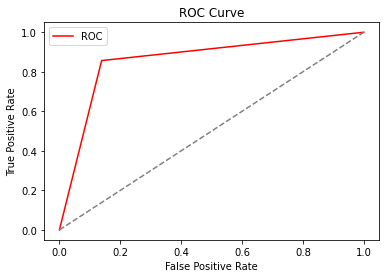

AUC: 0.8589834720977405


In [76]:
fpr, tpr, threshold = metrics.roc_curve(Yp_test, y_pred)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

auc = np.trapz(tpr,fpr)
print('AUC:', auc)

## b. K-Nearest Neighbors

In [83]:
knn_clf = KNeighborsClassifier().fit(Xp_train, Yp_train)
y_pred = knn_clf.predict(Xp_test)

In [84]:
y_pred

array([0, 1, 0, ..., 0, 1, 0])

In [85]:
acc_knn = accuracy_score(Yp_test, y_pred)
prec_knn = precision_score(Yp_test, y_pred)
rec_knn = recall_score(Yp_test, y_pred)
f1_knn = f1_score(Yp_test, y_pred)

print("Accuracy:", acc_knn)
print("Precision:", prec_knn)
print("Recall:", rec_knn)
print("F1 Score:", f1_knn)

Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732


In [86]:
neighbors = [1, 2, 3, 5, 7, 9, 10, 20, 50, 100]
for n in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=n).fit(Xp_train, Yp_train)
    y_pred = knn_clf.predict(Xp_test)
    print("N = %d" %n)
    print("Accuracy:", accuracy_score(Yp_test, y_pred))
    print("Precision:", precision_score(Yp_test, y_pred))
    print("Recall:", recall_score(Yp_test, y_pred))
    print("F1 Score:", f1_score(Yp_test, y_pred))

N = 1
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 2
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 3
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 5
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 7
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 9
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 10
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 20
Accuracy: 0.8548191308570041
Precision: 0.4213615023474178
Recall: 0.7737068965517241
F1 Score: 0.5455927051671732
N = 50
Accuracy: 0.85481913085

## c. Bagging

In [87]:
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection

In [88]:
tree = DecisionTreeClassifier(max_depth=3, random_state=20)

In [89]:
bagging = BaggingClassifier(base_estimator=tree, n_estimators=16, max_samples=200, bootstrap=True)

In [90]:
bagging.fit(Xp_train, Yp_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=20),
                  max_samples=200, n_estimators=16)

In [91]:
y_pred = bagging.predict(Xp_test)

In [92]:
acc_bag = accuracy_score(Yp_test, y_pred)
prec_bag = precision_score(Yp_test, y_pred)
rec_bag = recall_score(Yp_test, y_pred)
f1_bag = f1_score(Yp_test, y_pred)

print("Accuracy:", acc_bag)
print("Precision:", prec_bag)
print("Recall:", rec_bag)
print("F1 Score:", f1_bag)

Accuracy: 0.8194950230638505
Precision: 0.3698183511877038
Recall: 0.8556034482758621
F1 Score: 0.5164227642276423


### Hyperparameter Tuning

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [101]:
n_estimators = [10, 15, 20]
max_samples = [0.6, 0.8, 1.0]
max_features = [4, 5, 6]

In [123]:
p = make_scorer(precision_score, average='macro')
f1 = make_scorer(f1_score, average='macro')

In [103]:
grid = dict(n_estimators = n_estimators, max_samples = max_samples, max_features = max_features)
grid_search = GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier()), param_grid=grid, n_jobs=-1, cv=5, scoring=p)

In [104]:
grid_result = grid_search.fit(Xp_train, Yp_train)

In [105]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.935237 using {'max_features': 6, 'max_samples': 1.0, 'n_estimators': 20}


## d. Neural Network

In [106]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

In [109]:
#We only use PCA transformed data from this point on
mlp_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(150,100,50), max_iter=100, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=21)
mlp_clf.fit(Xp_train, Yp_train)

y_pred = mlp_clf.predict(Xp_test)

Iteration 1, loss = 0.31995996
Iteration 2, loss = 0.27436472
Iteration 3, loss = 0.25625935
Iteration 4, loss = 0.24765133
Iteration 5, loss = 0.24157494
Iteration 6, loss = 0.23626344
Iteration 7, loss = 0.23164930
Iteration 8, loss = 0.22760736
Iteration 9, loss = 0.22166760
Iteration 10, loss = 0.21768941
Iteration 11, loss = 0.21298843
Iteration 12, loss = 0.20847733
Iteration 13, loss = 0.20638728
Iteration 14, loss = 0.20023305
Iteration 15, loss = 0.19760133
Iteration 16, loss = 0.19291598
Iteration 17, loss = 0.18951463
Iteration 18, loss = 0.18473961
Iteration 19, loss = 0.18010336
Iteration 20, loss = 0.17712012
Iteration 21, loss = 0.17414222
Iteration 22, loss = 0.17029215
Iteration 23, loss = 0.16826224
Iteration 24, loss = 0.16406460
Iteration 25, loss = 0.16164877
Iteration 26, loss = 0.15838700
Iteration 27, loss = 0.15471887
Iteration 28, loss = 0.15401356
Iteration 29, loss = 0.15016810
Iteration 30, loss = 0.14739764
Iteration 31, loss = 0.14474009
Iteration 32, los

/Users/ojasbardiya/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [126]:
acc_nn = accuracy_score(Yp_test, y_pred)
prec_nn = precision_score(Yp_test, y_pred)
rec_nn = recall_score(Yp_test, y_pred)
f1_nn = f1_score(Yp_test, y_pred)

print("Accuracy:", acc_nn)
print("Precision:", prec_nn)
print("Recall:", rec_nn)
print("F1 Score:", f1_nn)

Accuracy: 0.8846807477543093
Precision: 0.49012567324955114
Recall: 0.5883620689655172
F1 Score: 0.5347698334965719


# 7. K-Fold Cross Validation - Using Stratified K-Fold

In [127]:
from sklearn.model_selection import KFold
from sklearn import model_selection

In [128]:
kfold = model_selection.StratifiedKFold(n_splits=5)

In [129]:
bag_model_kfold = BaggingClassifier(base_estimator=tree, n_estimators=6, max_samples=200, bootstrap=True)

nn_model_kfold = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=100, alpha=0.001,
                     solver='adam')

bag_results_kfold = model_selection.cross_val_score(bag_model_kfold, pca_data, df1_labels, cv=kfold, scoring=f1)

nn_results_kfold = model_selection.cross_val_score(nn_model_kfold, pca_data, df1_labels, cv=kfold, scoring=f1)


# Because we're collecting results from all runs, we take the mean value
print(" Bagging f1 score: %.2f%%" % (bag_results_kfold.mean()*100.0)) 

print("Neural Network f1 score: %.2f%%" % (nn_results_kfold.mean()*100.0))

/Users/ojasbardiya/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ojasbardiya/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ojasbardiya/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ojasbardiya/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


 Bagging f1 score: 54.03%
Neural Network f1 score: 43.85%


# 8. Discussion

### Since we're trying to classify whether a person will subscribe to a bank term deposit, it makes sense to look at precision as the primary evaluation metric since we want to minimize the number of false positives as a greater number of false positives would mean more resources invested in consumers who likely won't start a deposit. It also makes sense to consider F1 score as an important metric since the original dataset is highly imbalanced. 

### Out of the models we've chosen, an MLP Neural Network gives the highest precision of ~49%. This far too low (a coin toss has better odds) so it doesn't make much sense to actually use this model in business decisions. 

### A bagging classifier (with its base classifier as a decision tree) provides an F1 score of ~54% but this is still far too inadequate to be actually considered as high-performing.

### A possible reason for the low precision and F1 score is the highly imbalanced nature of the original dataset. Artificially balancing it through oversampling via SMOTE often results in overfitting and makes the model less robust.